In [1]:
import os
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import librosa
import librosa.display
import tensorflow as tf
import tensorflow_io as tfio

import src.data
import src.models

plt.style.use('seaborn')
def reload():
    importlib.reload(src.data)
    importlib.reload(src.models)

In [2]:
batch_size = 64

In [11]:
reload()
ds = src.data.get_podcast_dataset("singular").repeat()

In [10]:
%%time
for example in ds.take(batch_size):
    pass

CPU times: user 767 ms, sys: 40.2 ms, total: 807 ms
Wall time: 1.66 s


In [5]:
ds = src.data.get_podcast_dataset("sequential").repeat()

In [6]:
%%time
for example in ds.take(batch_size):
    pass

CPU times: user 978 ms, sys: 43.2 ms, total: 1.02 s
Wall time: 2.49 s


In [7]:
ds = src.data.get_podcast_dataset("random").repeat()

In [8]:
%%time
for example in ds.take(batch_size):
    pass

CPU times: user 871 ms, sys: 57.1 ms, total: 929 ms
Wall time: 2.76 s


In [9]:
ds = src.data.get_podcast_dataset("singular", data_path="/mnt/storage/cdtdisspotify/raw/").repeat()

In [10]:
%%time
for example in ds.take(batch_size):
    pass

CPU times: user 477 ms, sys: 26 ms, total: 503 ms
Wall time: 452 ms


In [11]:
ds = src.data.get_podcast_dataset("sequential", data_path="/mnt/storage/cdtdisspotify/raw/").repeat()

In [12]:
%%time
for example in ds.take(batch_size):
    pass

CPU times: user 907 ms, sys: 21.2 ms, total: 929 ms
Wall time: 846 ms


In [13]:
ds = src.data.get_podcast_dataset("random", data_path="/mnt/storage/cdtdisspotify/raw/").repeat()

In [14]:
%%time
for example in ds.take(batch_size):
    pass

CPU times: user 952 ms, sys: 36.1 ms, total: 988 ms
Wall time: 906 ms


In [3]:
df = src.data.get_self_supervised_data().repeat()

In [4]:
%%time
for example in df.take(batch_size):
    pass

CPU times: user 1.94 s, sys: 711 ms, total: 2.65 s
Wall time: 216 ms


In [15]:
ex = None
for example in ds.take(1):
    ex = example

/unix/cdtdisspotify/env/envs/podcasts/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/unix/cdtdisspotify/env/envs/podcasts/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


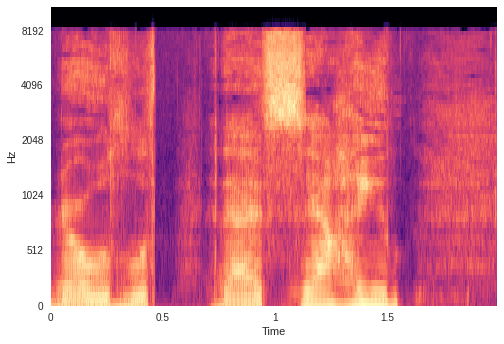

In [16]:
anchor = tf.math.l2_normalize(ex["anchor"], epsilon=1e-9)
mels_anchor = src.data.extract_log_mel_spectrogram(anchor)
frames_anchors = mels_anchor[Ellipsis, tf.newaxis]
librosa.display.specshow(np.rot90(mels_anchor.numpy(), k=3), x_axis='time', y_axis='mel', sr=44100, hop_length=160)

In [17]:
from IPython.display import Audio
Audio(anchor.numpy(), rate=44100)

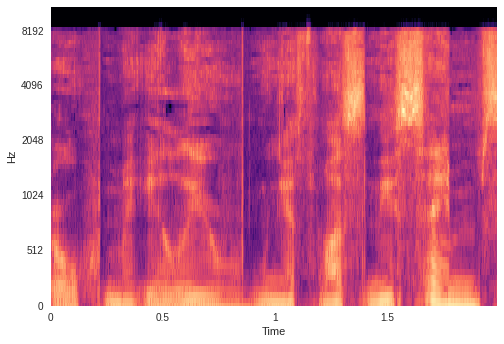

In [18]:
positive = tf.math.l2_normalize(ex["positive"], epsilon=1e-9)
mels_positive = src.data.extract_log_mel_spectrogram(positive)
frames_positive = mels_positive[Ellipsis, tf.newaxis]
librosa.display.specshow(np.rot90(mels_positive.numpy(), k=3), x_axis='time', y_axis='mel', sr=44100, hop_length=160)

In [19]:
from IPython.display import Audio
Audio(positive.numpy(), rate=44100)

In [117]:
ds = get_podcast_dataset("sequential", data_path="/mnt/storage/cdtdisspotify/raw/").repeat()
ds = ds.batch(128, drop_remainder=True)

In [120]:
%%time
ex = None
for example in ds.take(1):
    ex = example

CPU times: user 6.9 s, sys: 92.5 ms, total: 6.99 s
Wall time: 2.46 s


In [45]:
from IPython.display import Audio
Audio(ex["sample"].numpy(), rate=16000)

In [147]:
import tensorflow_datasets as tfds
def get_tfds_dataset(method="singular", dataset="crema_d", shuffle_buffer=1000, feature="log_mel"):
    """Reads TFDS audio data as tf dataset."""

    @tf.function
    def _parse_example(audio, _):
        
        
        
        sample = tf.cast(audio, tf.float32) / float(tf.int16.max)
        sample = tf.math.l2_normalize(sample, epsilon=1e-9)
        return {"sample": sample}

    if dataset == "librispeech":
        split = "train_clean360"
    else:
        split = "train"

    ds = tfds.load(
        dataset,
        split=split,
        as_supervised=True,
        data_dir="/mnt/storage/cdtdisspotify/tensorflow_datasets/",
    )
    ds = ds.shuffle(shuffle_buffer, reshuffle_each_iteration=True)
    ds = ds.map(_parse_example, num_parallel_calls=None)
    if feature == "log_mel":
        ds = ds.map(extract_log_mel, num_parallel_calls=tf.data.AUTOTUNE)
    return ds

def random_segment(waveform, seg_length=16000):
    """Extract a random segment from a waveform."""
    padding = tf.maximum(seg_length - tf.shape(waveform)[0], 0)
    left_pad = padding // 2
    right_pad = padding - left_pad
    padded_waveform = tf.pad(waveform, paddings=[[left_pad, right_pad]])
    return tf.image.random_crop(padded_waveform, [seg_length])

In [148]:
ds = get_tfds_dataset(method="singular")

In [149]:
%%time
ex = None
for example in ds.take(1):
    ex = example

CPU times: user 1.91 s, sys: 256 ms, total: 2.17 s
Wall time: 149 ms


In [150]:
ex

{'sample': <tf.Tensor: shape=(36409,), dtype=float32, numpy=
 array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -1.3357313e-05, -1.0389022e-05, -1.1873167e-05], dtype=float32)>}

In [152]:
from IPython.display import Audio
Audio(ex["sample"], rate=16000)